In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import t

from knobs_functions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
primary_score_list

['Reock',
 'Polsby-Popper',
 'cut edges',
 'Dem seats',
 'efficiency gap',
 'mean-median',
 'seat bias',
 'competitive districts',
 'average margin',
 'MMD black',
 'MMD hispanic',
 'county splits',
 'counties split',
 'MMD coalition']

In [3]:
# crate dictionaries to score the mean and std of each score array
score_mean = dict()
score_std = dict()

for state, chamber in state_chamber_list:
    for score in primary_score_list:
        for ensemble in ensemble_list+['base0']:
            a = fetch_score_array(state, chamber, ensemble, score)
            score_mean[state, chamber, ensemble, score] = np.mean(a)
            score_std[state, chamber, ensemble, score] = np.std(a)

In [4]:
# Normalize the scores relative to the mean and sdt of the base0 ensemble
score_norm = dict()
for state, chamber in state_chamber_list:
    for score in primary_score_list:
        for ensemble in ensemble_list+['base0']:
            if ensemble == 'base0':
                score_norm[state, chamber, ensemble, score] = 0
            else:
                score_norm[state, chamber, ensemble, score] = (
                    (score_mean[state, chamber, ensemble, score] - score_mean[state, chamber, 'base0', score]) /
                    score_std[state, chamber, 'base0', score]
                )

In [5]:
# average over the states and chambers
score_norm_avg = dict()
for ensemble in ensemble_list+['base0']:
    for score in primary_score_list:
        score_norm_avg[ensemble, score]  = np.mean(
            [score_norm[state, chamber, ensemble, score] for state, chamber in state_chamber_list])

In [6]:
# create re-ordering of the ensemble list
my_ensemble_list = ['distpair_ust', 'ust', 'reversible', 'distpair', 'base0', 'county25', 'county50', 'county75', 'county100']

In [7]:
def plot_scores(score_list, state='All', chamber='All',
                my_ensemble_list=my_ensemble_list, filename=None, p_value=None):
    n = len(score_list)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(6, 1.2 * n), sharey=True)

    if n == 1:
        axes = [axes]  # Make it iterable if there's only one subplot

    for ax, score in zip(axes, score_list):
        # Get x-values for this score
        if state == 'All':
            X = [score_norm_avg[ensemble, score] for ensemble in my_ensemble_list]
        else:
            X = [score_norm[state, chamber, ensemble, score] for ensemble in my_ensemble_list]

        # Get labels
        L = [ensemble_name_dict_for_plots[ensemble] for ensemble in my_ensemble_list]

        # Assign colors
        unique_labels = list(dict.fromkeys(L))
        colors = plt.cm.tab10.colors
        label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

        # --- Vertical staggering setup ---
        y_offsets = [0.04, 0.08, 0.12, 0.16]  # Repeat cycle

        # Plot points and staggered labels
        for i, (x, label) in enumerate(zip(X, L)):
            y = y_offsets[i % len(y_offsets)]
            ax.plot(x, 0, 'o', color=label_to_color[label], markersize=8)
            ax.text(x, y, label, color=label_to_color[label],
                    ha='center', va='bottom', rotation=45, fontsize=10)

        # Draw shaded box for p-value region if applicable
        if p_value is not None:
            n_samples = 20000
            df = 2 * n_samples - 2
            t_crit = t.ppf(1 - p_value / 2, df)
            stds_apart = t_crit * math.sqrt(2 / n_samples)
            ax.axvspan(-stds_apart, stds_apart, color='cyan', alpha=0.4)

        # Style
        ax.set_yticks([])
        ax.set_ylim(-0.1, 0.18)  # Adjusted to allow for staggered labels
        ax.set_xlabel(f'Normalized {score}', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

    # Title
    title = (f'{state} {chamber}: Normalized score by ensemble'
             if state != 'All' else
             'Normalized score by ensemble (averaged over states and chambers)')
    fig.suptitle(title, fontsize=14, y=1.02)

    plt.tight_layout(h_pad=0.5)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [8]:
scores_other_than_MMD = ['Reock',
 'Polsby-Popper',
 'cut edges',
 'Dem seats',
 'efficiency gap',
 'mean-median',
 'seat bias',
 'competitive districts',
 'average margin',
 'county splits',
]

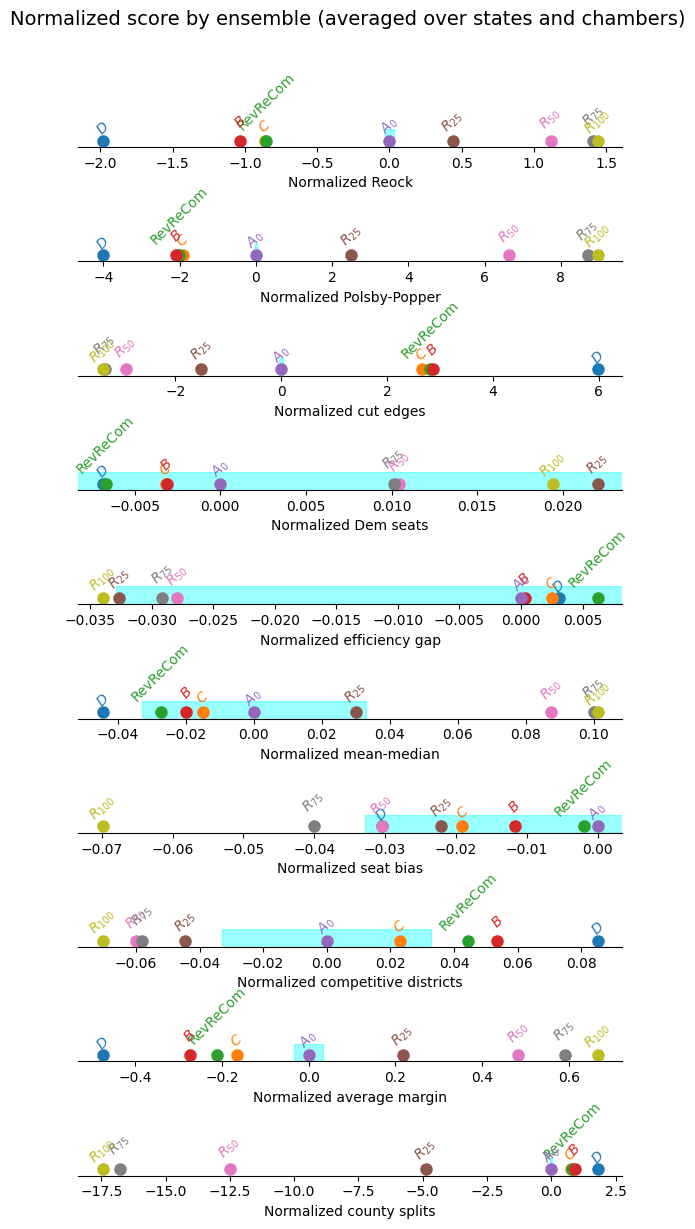

In [9]:
plot_scores(scores_other_than_MMD, state='All', chamber='All', p_value=.001, filename='graphs/score_dots_all.png')

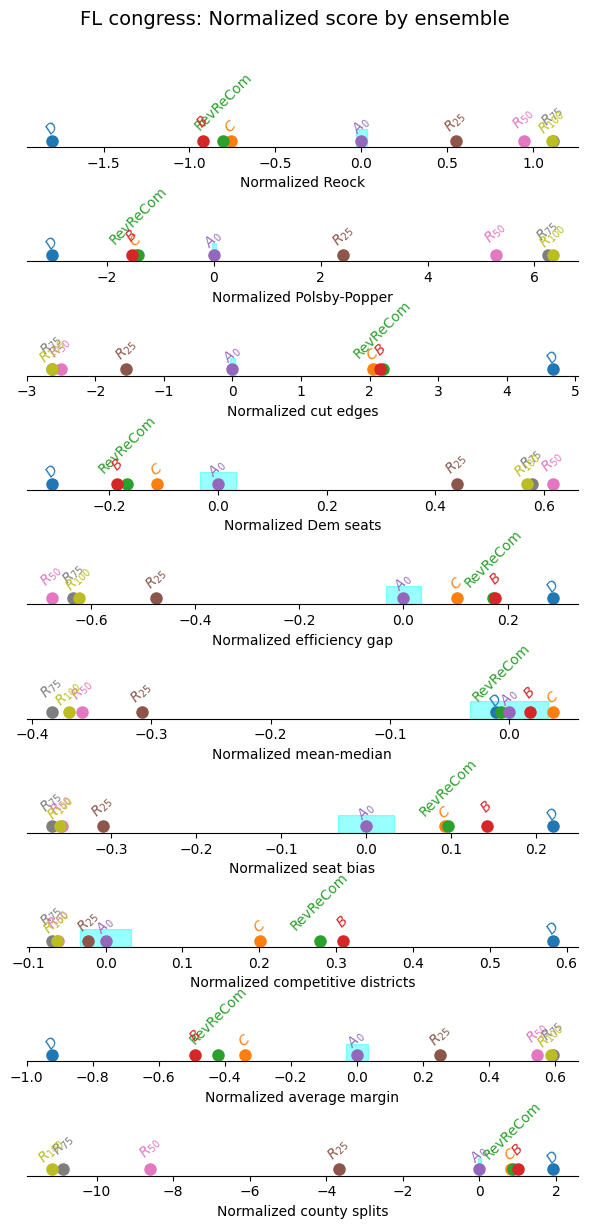

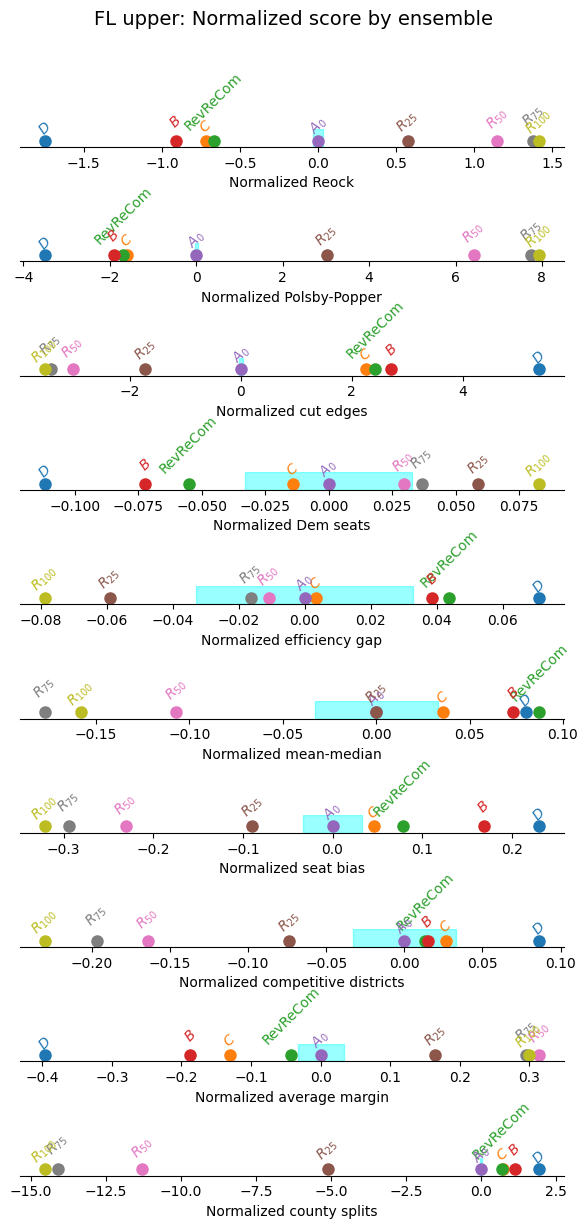

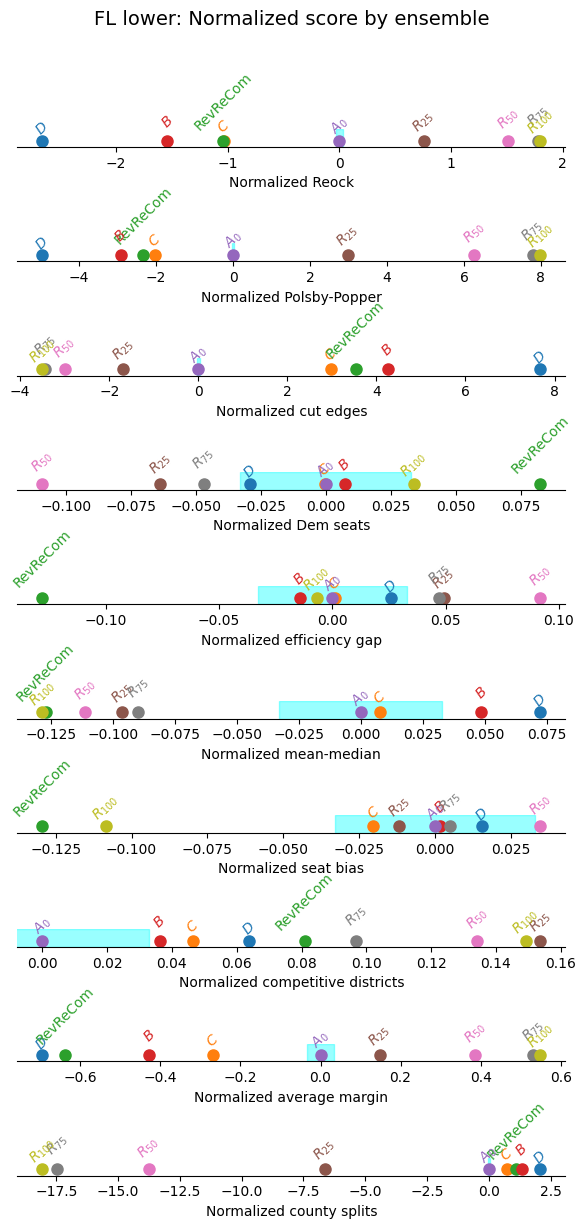

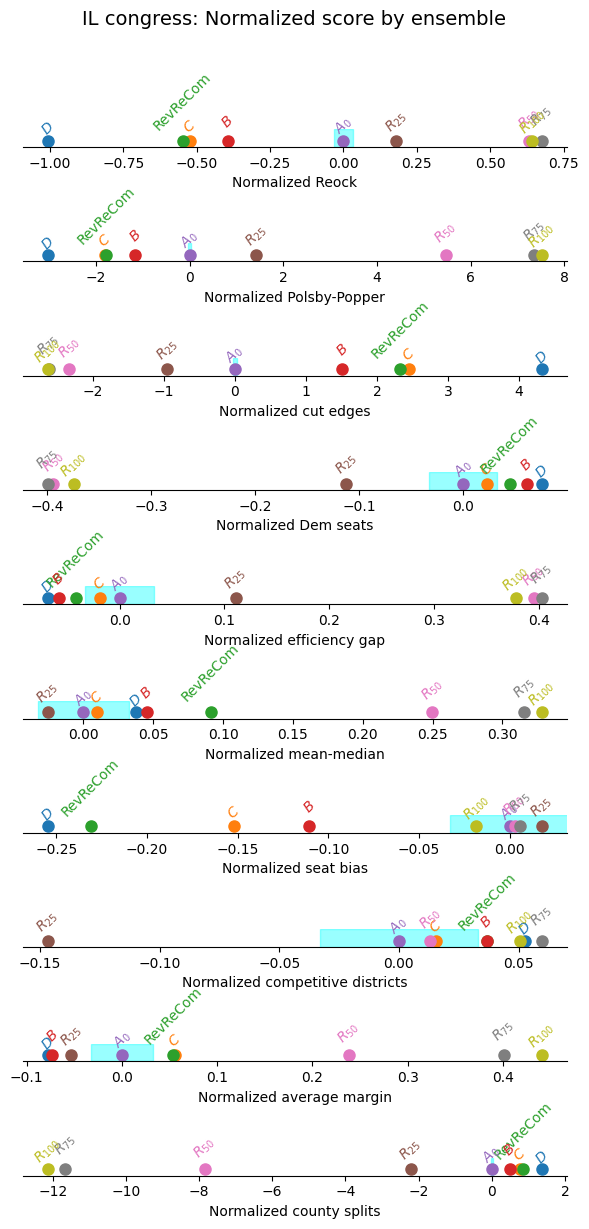

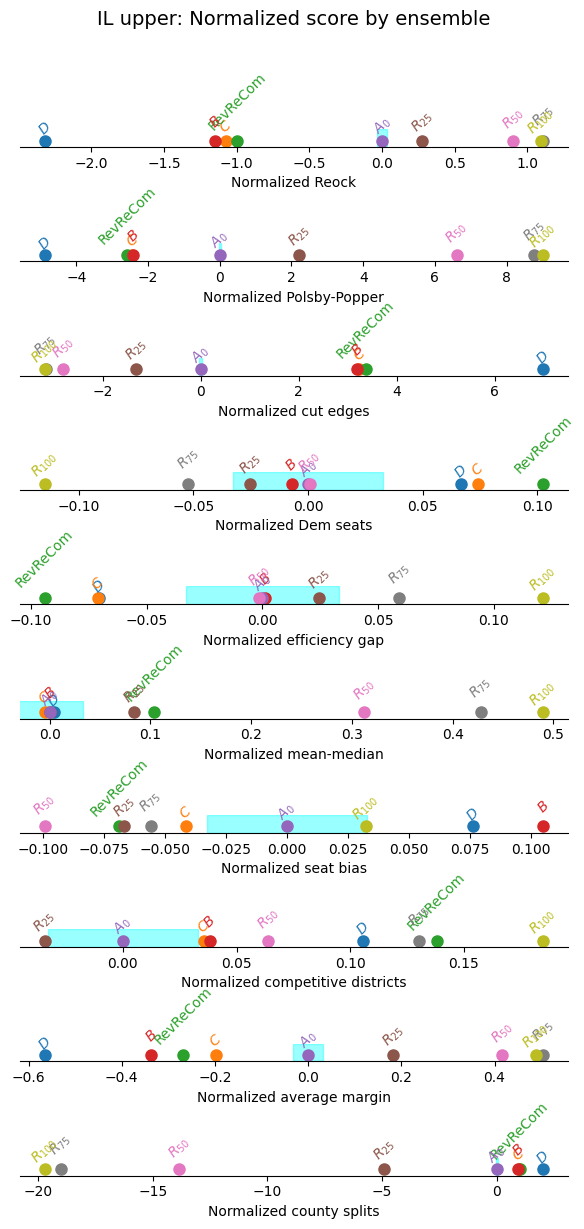

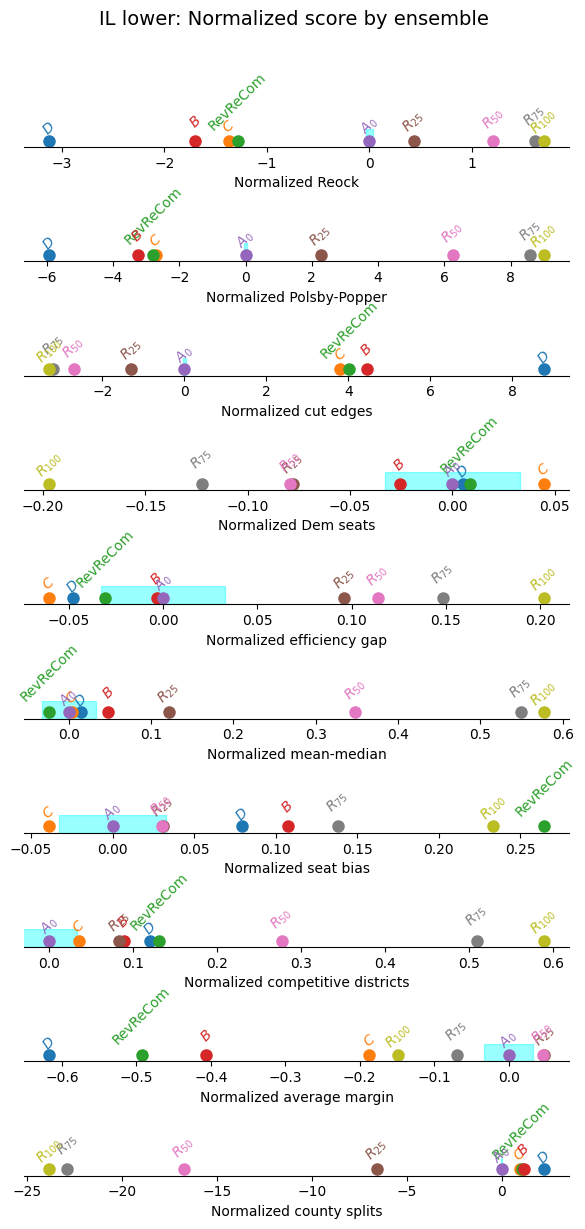

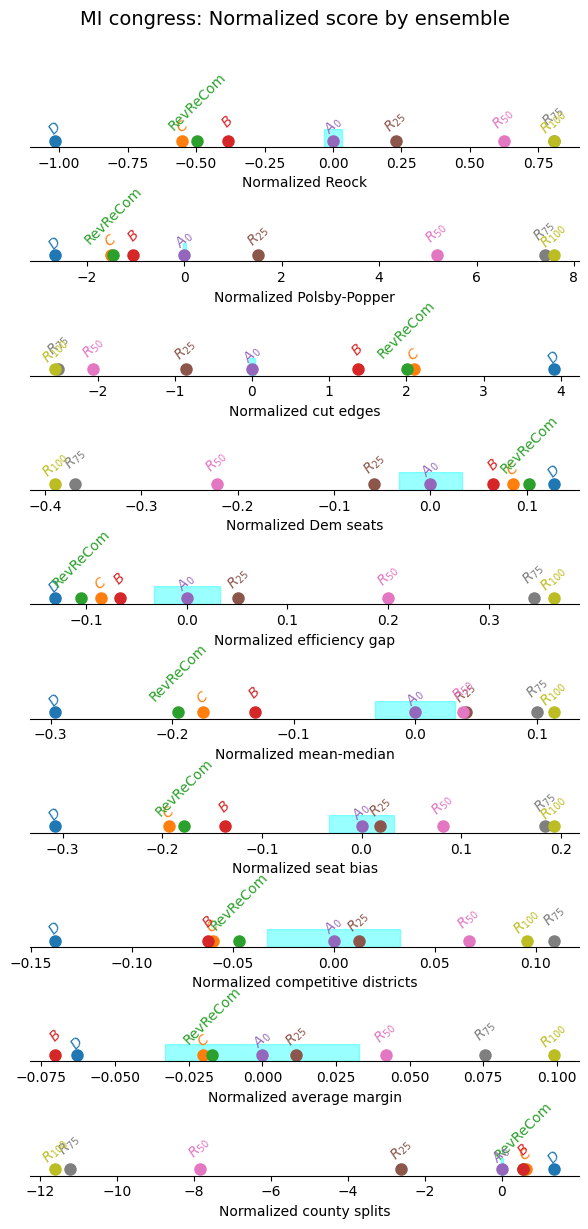

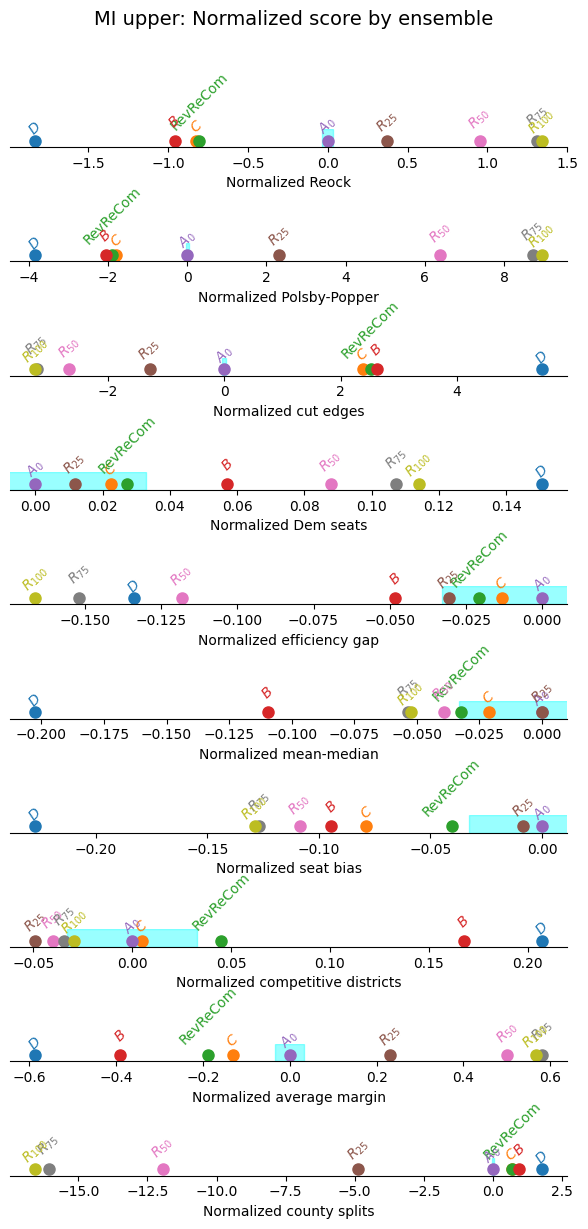

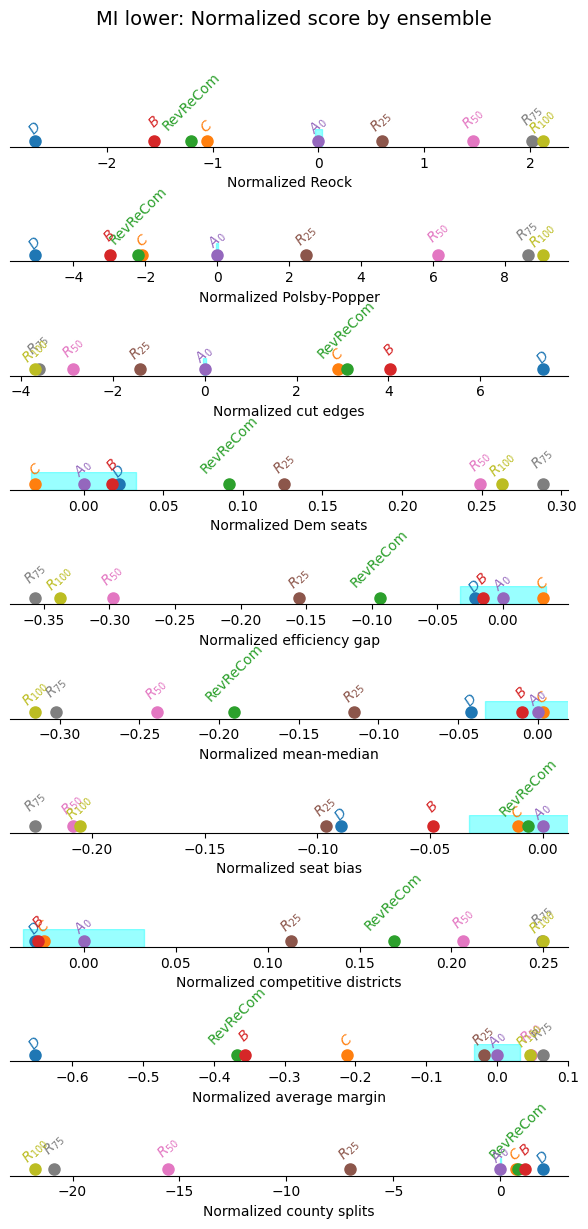

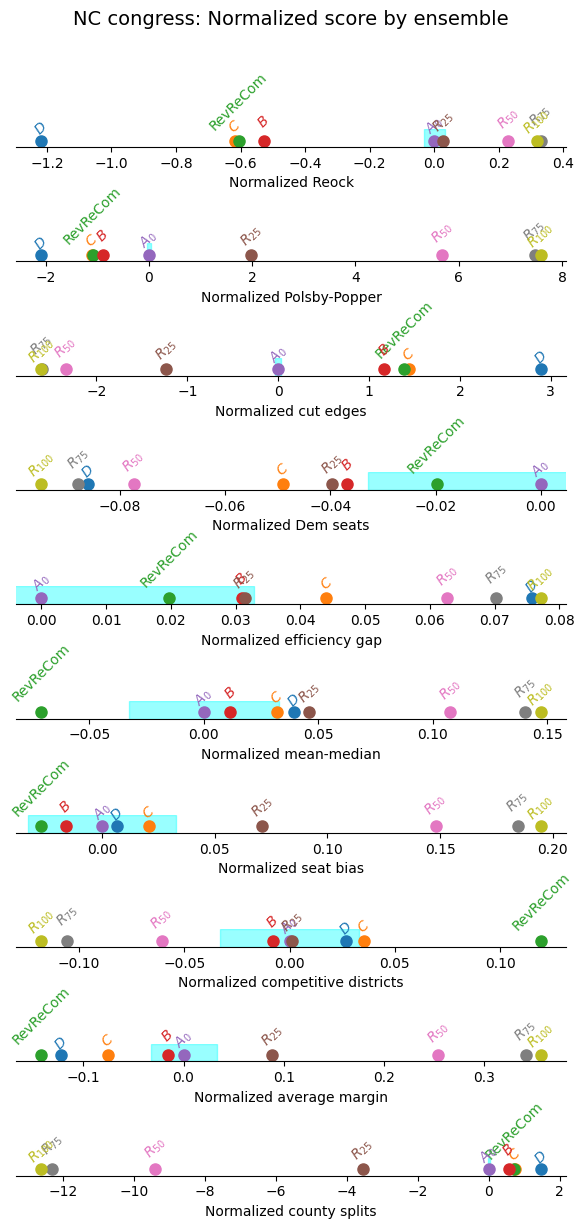

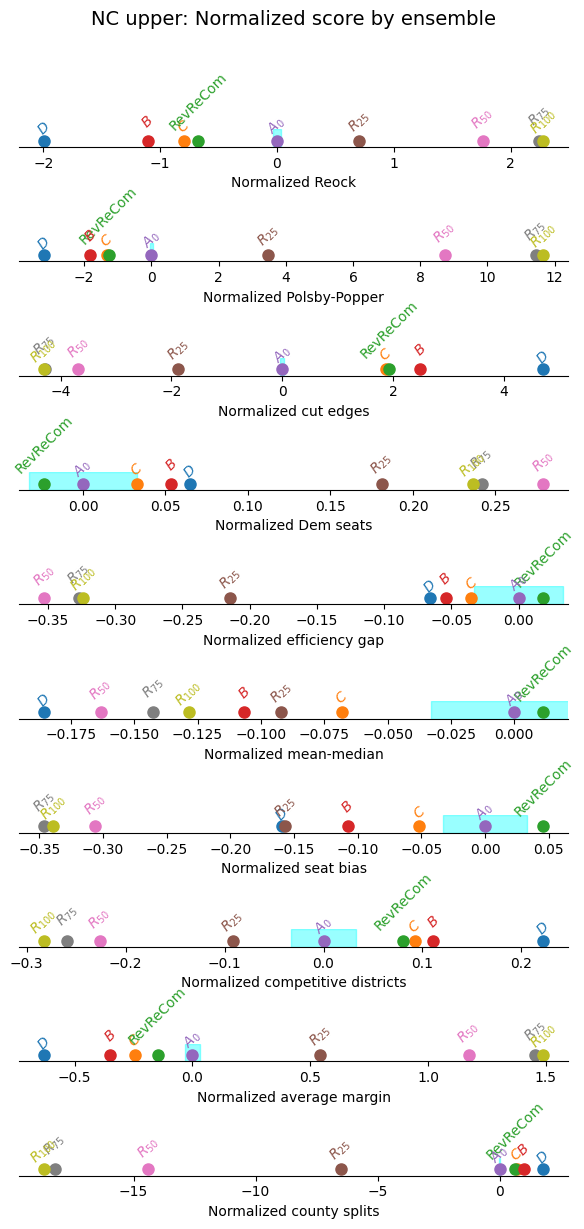

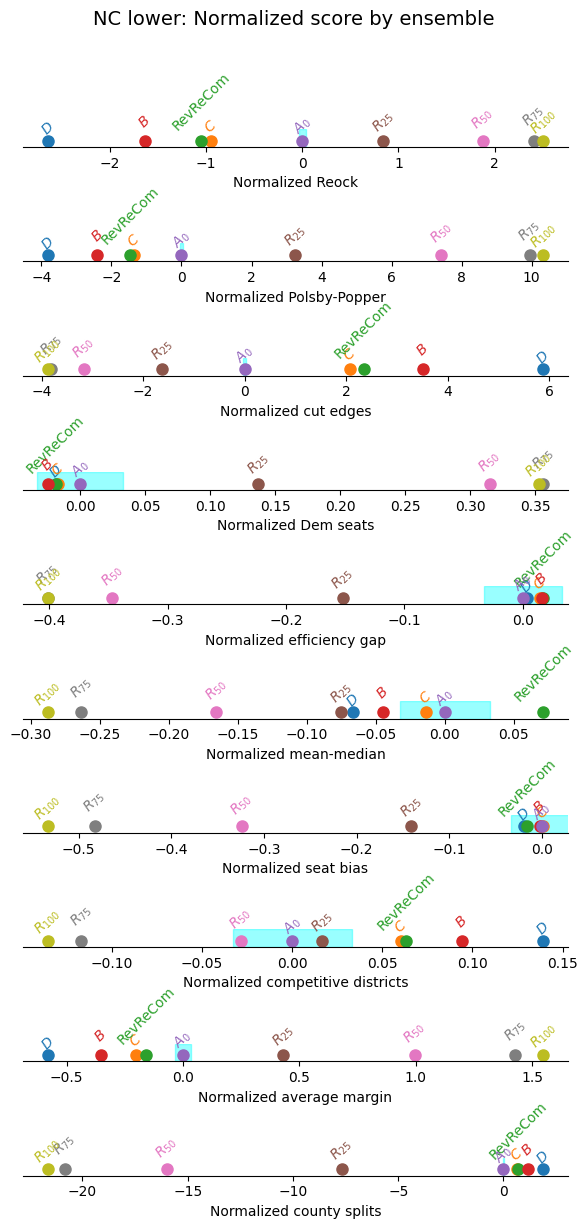

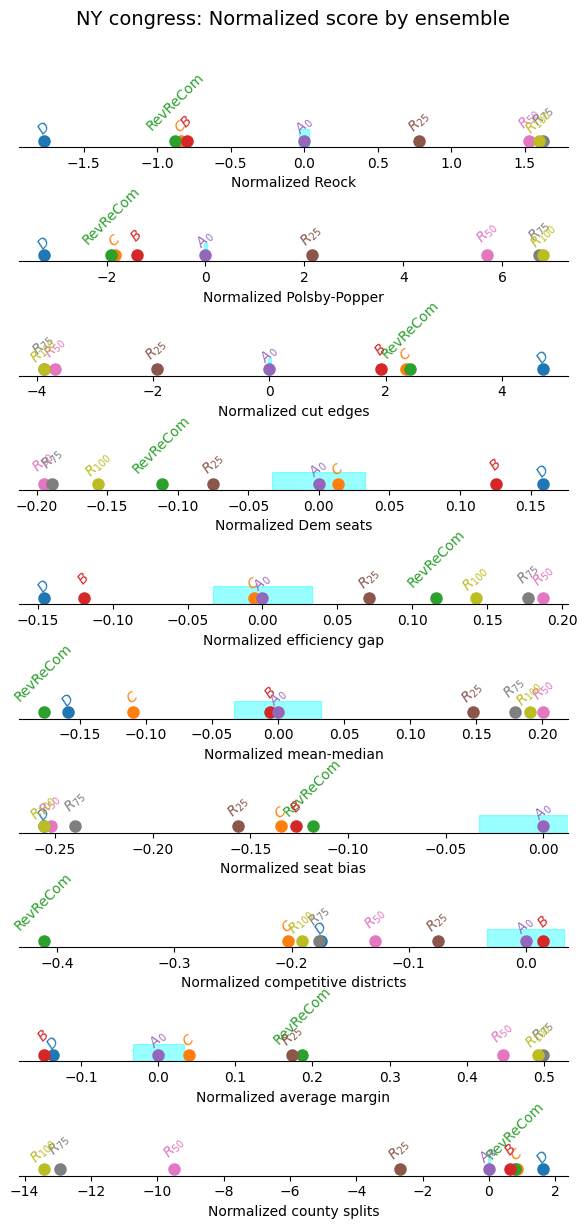

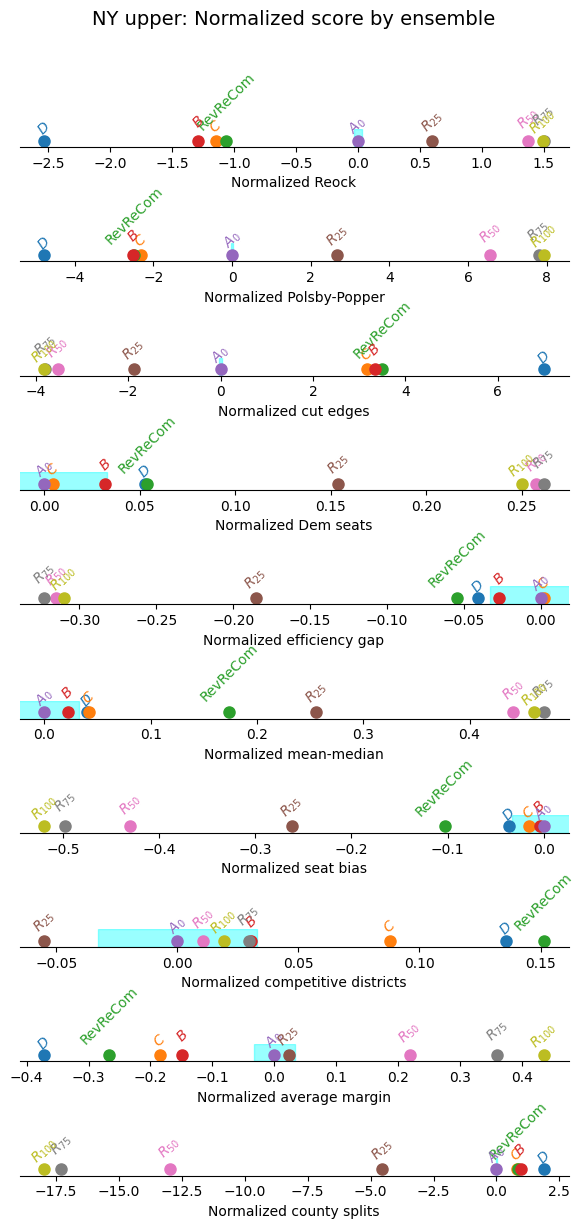

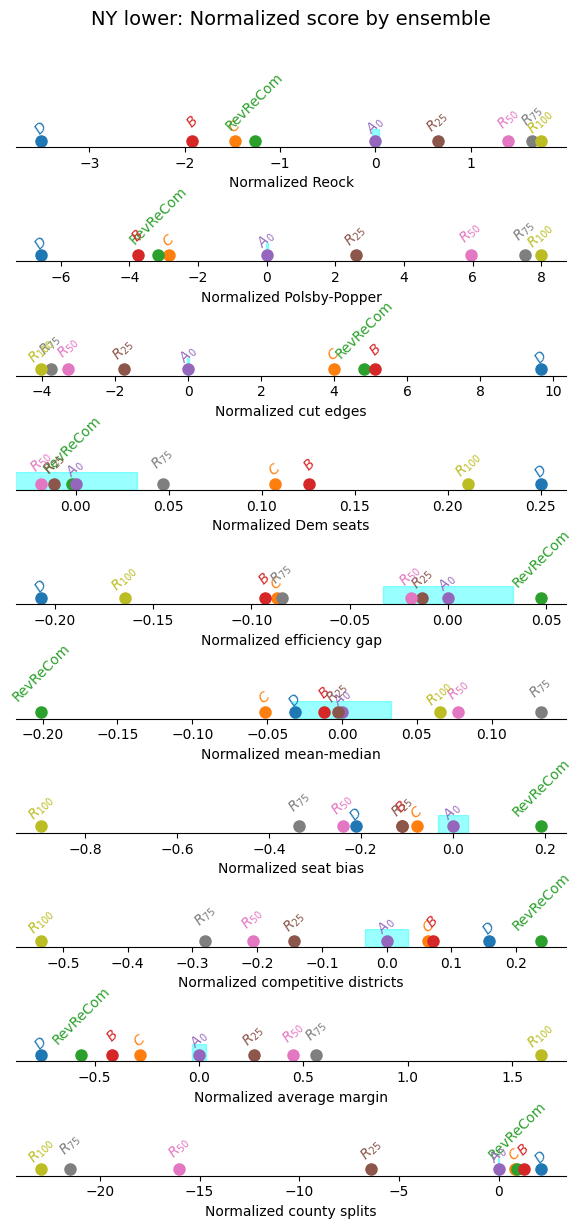

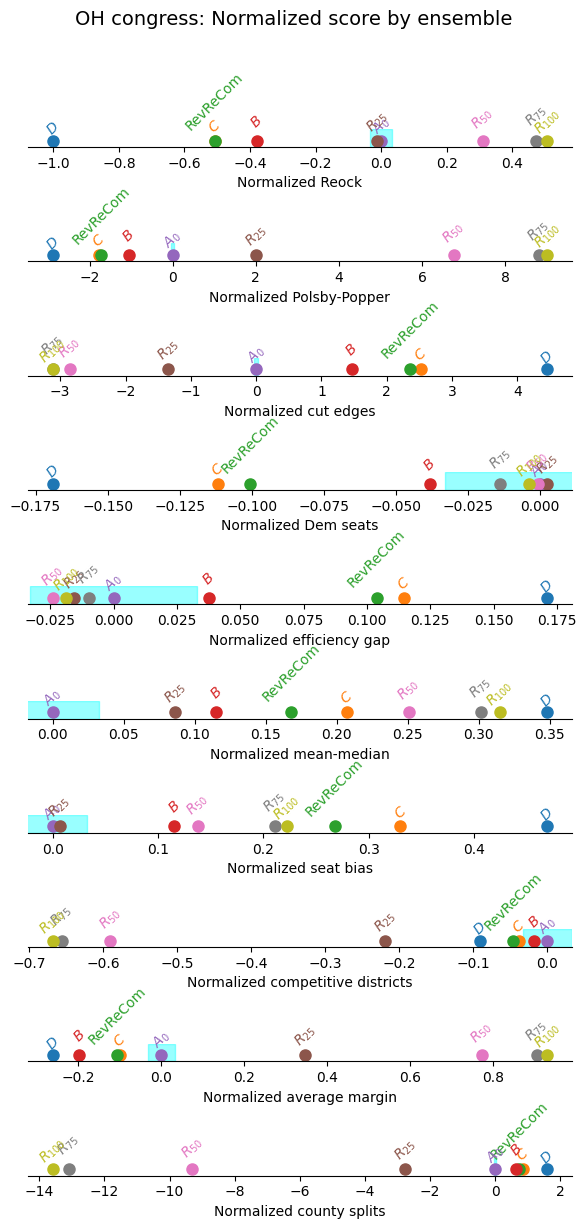

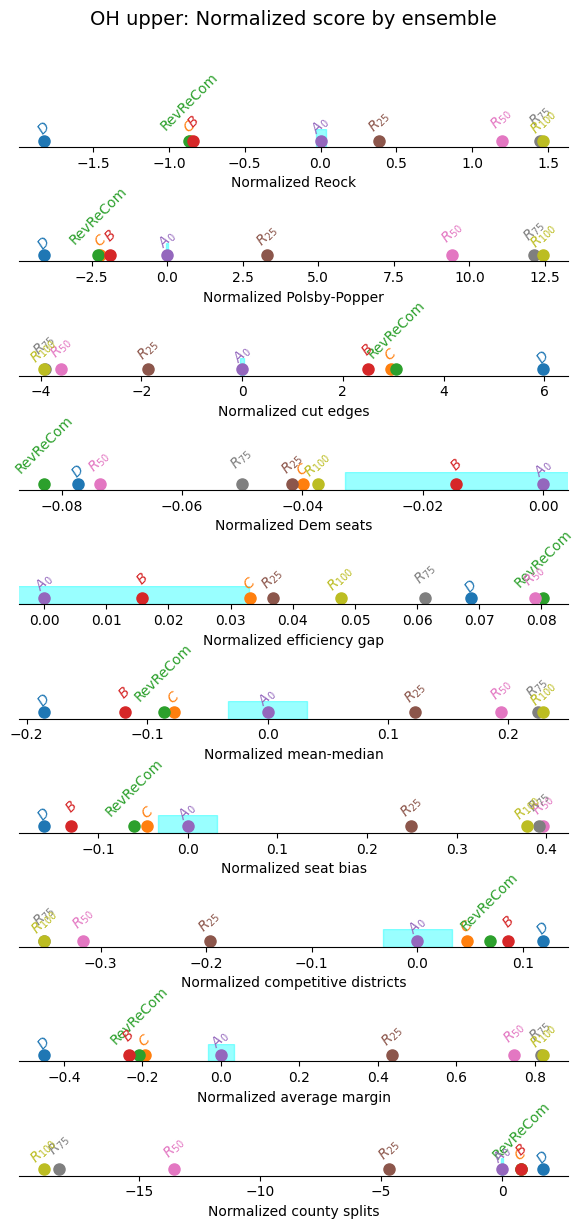

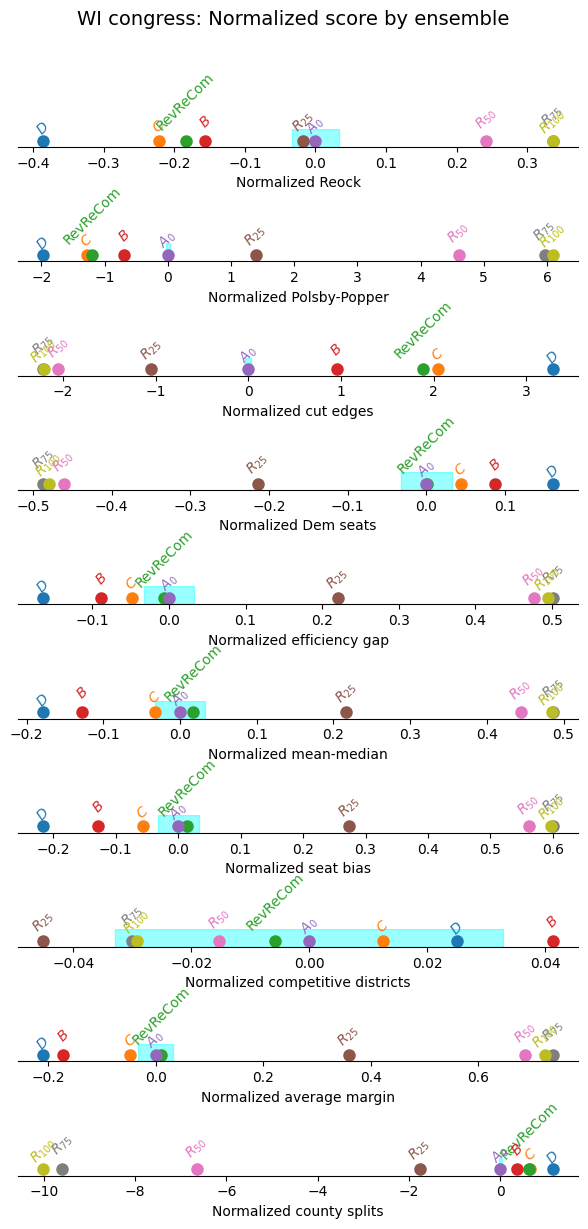

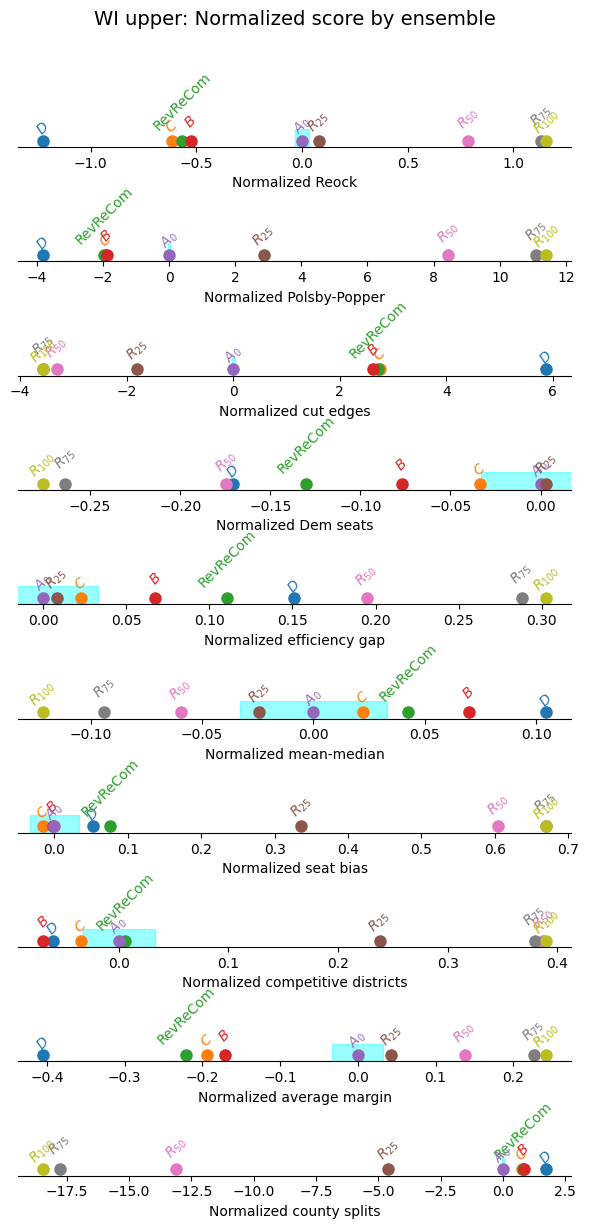

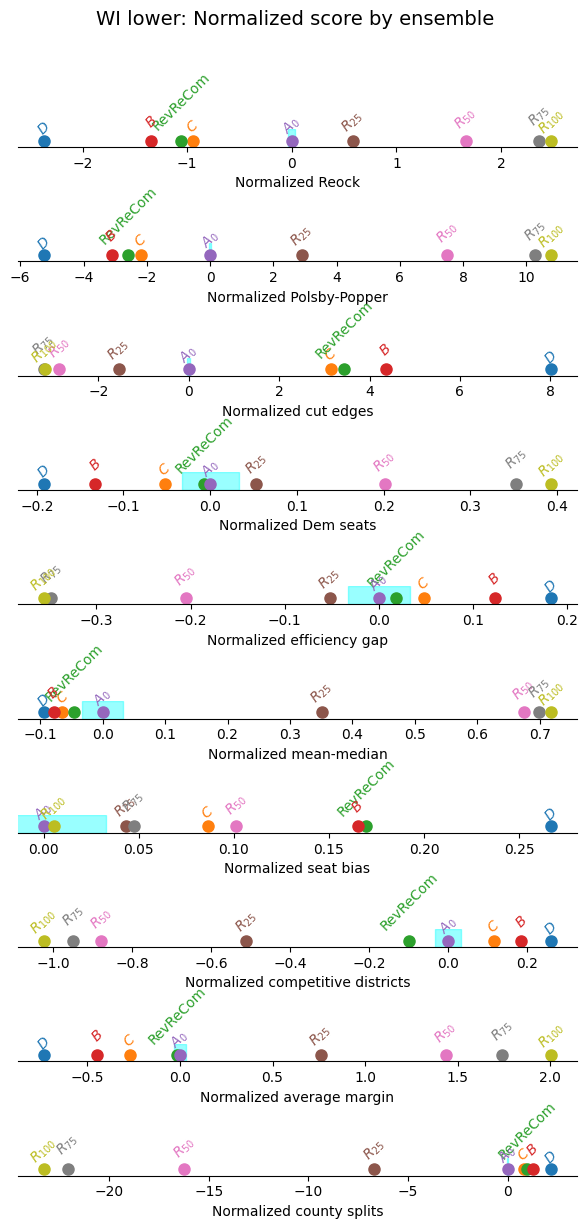

In [10]:
for state, chamber in state_chamber_list:
    plot_scores(scores_other_than_MMD, state, chamber, p_value=.001,
                filename=f'dot_plots/score_dots_{state}_{chamber}.png')